In [ ]:
# default_exp player

# player
> Mathematical players for games of truth and consequences

In [ ]:
# hide
from nbdev.showdoc import *

%load_ext nb_black
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

<IPython.core.display.Javascript object>

In [ ]:
# export
import csv
import numpy as np

from truthiness import gym
from truthiness.game import available_moves
from truthiness.plot import plot_available
from truthiness.game import random_move
from truthiness.game import create_maze

<IPython.core.display.Javascript object>

# a run function
First we make a run function to our players. 
- An 'episode' is a full game of play. Change `num_episdoes` to play more or less.
- Each episode uses a different random seed.
- Data for each game can be logged to csv file. Change `name` from `None`.

In [ ]:
# export
def run(
    n,
    player,
    num_episodes=10,
    num_steps=2,
    env_name="ShameGame1",
    env_kwargs=None,
    maze_kwargs=None,
    name=None,
    seed=None,
):
    """Play some games."""

    # Sanity
    num_episodes = int(num_episodes)
    if num_episodes < 1:
        raise ValueError("num_episode must be > 0")
    if maze_kwargs is None:
        maze_kwargs = {}
    if env_kwargs is None:
        env_kwargs = {}

    # Get the env
    prng = np.random.RandomState(seed)
    Env = getattr(gym, env_name)
    maze, prng = create_maze(n, prng=prng, **maze_kwargs)
    env = Env(n, maze=maze, seed=seed, **env_kwargs)

    # Init logging. Save data as tuples:
    # (n, t, x, y, e, q)
    table = []
    mazes = []
    Es = []
    Qs = []
    moves = []

    # !
    for i in range(num_episodes):
        # Reconfig the env
        maze, prng = create_maze(n, prng=prng, **maze_kwargs)
        mazes.append((i, maze))

        # Reset
        done = False
        t = 0

        env.set_maze(maze)
        x, y, Q, E = env.reset()
        Es.append((i, E))
        Qs.append((i, Q))
        moves.append((i, t, x, y))

        # -
        while (not done) and (t < num_steps):
            t += 1

            # Choose and act
            available = env.moves()
            x, y = player(E, Q, available)
            moves.append((i, t, x, y))
            state, reward, done, _ = env.step((x, y))

            # Log data
            e, q = reward
            row = (i, t, x, y, e, q)
            table.append(row)

            # Shift
            x, y, Q, E = state

    # Save to disk?
    if name is not None:
        save_table(name, table)

    return moves, mazes, Es, Qs

<IPython.core.display.Javascript object>

# utilities
Define functions that will be helpful in then defining players

In [ ]:
# export
def save_table(name, results):
    with open(name, mode="w") as handle:
        # Init
        writer = csv.writer(handle)

        # Header
        head = ("n", "t", "x", "y", "E", "Q")
        writer.writerow(head)

        # Results
        for row in results:
            writer.writerow(row)

<IPython.core.display.Javascript object>

In [ ]:
# export
def extract_moves(episode, moves):
    selected = []
    for m in moves:
        if np.isclose(m[0], episode):
            selected.append((m[2], m[3]))
    return selected

<IPython.core.display.Javascript object>

In [ ]:
# export
def extract_board(episode, boards):
    for b in boards:
        if np.isclose(b[0], episode):
            return b[1]

<IPython.core.display.Javascript object>

In [ ]:
# export
def move_filter(board, moves):
    """Returns a list of values/conseqeunces for each move
    on an E or Q board.
    """
    return [board[x, y] for (x, y) in moves]

<IPython.core.display.Javascript object>

# all players 

Here we define different simple players and dispositions to truth and consequences. 
- Honesty: $max\ E_{i,j}$
- Planned honesty: $argmax_{\pi} \sum_P E_{i,j}$
- Sensitive: $min\ Q_{i,j}$
- Planned sensitive: $argmin_{\pi} \sum_P Q_{i,j}$
- Evil: $max\ Q_{i,j}$
- Planned evil: $argmax_{\pi} \sum_P Q_{i,j}$
- Foraging: $max\ \frac{E_{i,j}}{Q_{i,j}}$
- Planned foraging: $argmax_{\pi} \sum_P \frac{E_{i,j}}{Q_{i,j}}$
- Random

We also consider a couple more complex approaches which swtich amoung the simple policies

**TODO**

# a random player
They play by making random moves. Simple and bad.

In [ ]:
# export
class Random:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        i = self.prng.randint(0, len(moves))

        return moves[i]

<IPython.core.display.Javascript object>

[(1, 4), (2, 4), (7, 4), (6, 4), (6, 1)]


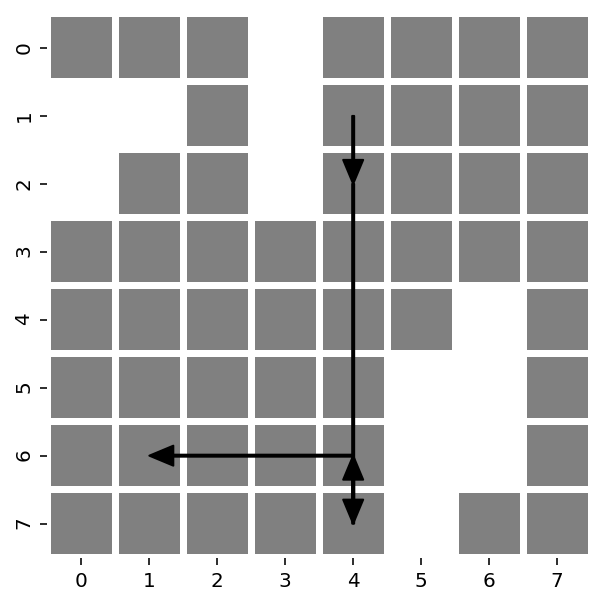

<IPython.core.display.Javascript object>

In [ ]:
# hide
from truthiness.plot import plot_maze

(
    moves,
    mazes,
    Es,
    Qs,
) = run(8, Random(), num_episodes=1, num_steps=4, seed=10)

selected = extract_moves(0, moves)
maze = extract_board(0, mazes)
print(selected)

plot_maze(maze, selected, plot=True, height=5, width=5)

# curious players

Choose the move with the most information value

In [ ]:
# export
class Curious:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        values = move_filter(E, moves)
        best = np.argmax(values)

        return moves[best]

<IPython.core.display.Javascript object>

[(1, 4), (4, 4), (0, 4), (0, 7), (2, 7)]


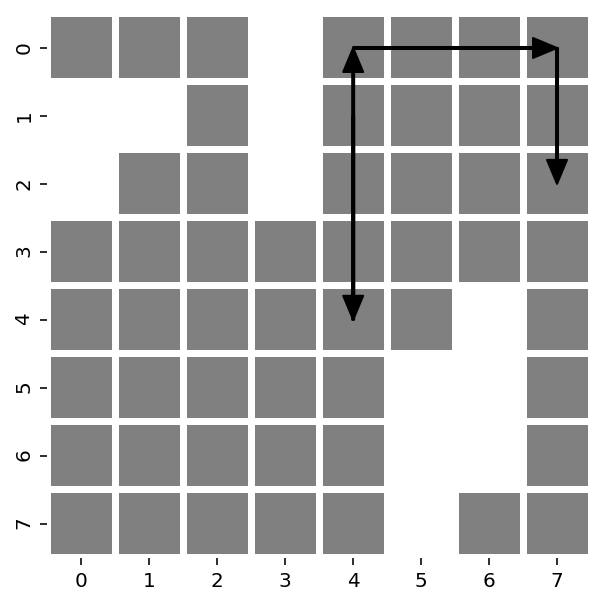

<IPython.core.display.Javascript object>

In [ ]:
# hide
from truthiness.plot import plot_maze

(
    moves,
    mazes,
    Es,
    Qs,
) = run(8, Curious(), num_episodes=1, num_steps=4, seed=10)

selected = extract_moves(0, moves)
maze = extract_board(0, mazes)
print(selected)

plot_maze(maze, selected, plot=True, height=5, width=5)

Try and choose the move that can lead to the most information over the whole best possible path

In [ ]:
# export
class CuriousMCTS:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        pass
        # TODO - do MCTS to find the best path overall
        # moves.
        return moves[i]

# sensitive players

Choose the move with the least consequences

In [ ]:
# export
class Sensitive:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        values = move_filter(Q, moves)
        best = np.argmin(values)

        return moves[best]

In [ ]:
run(8, Sensitive(), num_episodes=1)

Try and choose the move that can lead to the least consequences over the whole best possible path

In [ ]:
# export
class SensitiveMCTS:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        pass
        # TODO - do MCTS to find the best path overall
        # moves.
        return moves[i]

# evil players

Choose the move with the worst consequences

In [ ]:
# export
class Evil:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        values = move_filter(Q, moves)
        worst = np.argmax(values)

        return moves[worst]

In [ ]:
run(8, Evil(), num_episodes=1)

Try and choose the move that can lead to the worst consequences over the whole best possible path

In [ ]:
# export
class EvilMCTS:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        # TODO
        pass

        return moves[i]

# foraging players

Choose the move with the best ratio of $\frac{E}{Q}$

In [ ]:
# export
class OptimalForage:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        values = move_filter(E / Q, moves)
        best = np.argmax(values)

        return moves[best]

In [ ]:
run(8, OptimalForage(), num_episodes=2)

Try and choose the move that can lead to the best ratio of $\frac{E}{Q}$ over the whole best possible path

In [ ]:
# export
class OptimalForageMCTS:
    def __init__(self, prng=None):
        if prng is None:
            self.prng = np.random.RandomState()
        else:
            self.prng = prng

    def __call__(self, E, Q, moves):
        return self.forward(E, Q, moves)

    def forward(self, E, Q, moves):
        pass

        return moves[best]